# Workshop 2: Connectivity principles and structure function analysis

In [1]:
mat_version = 1169

import os
import sys

HOME = os.path.expanduser("~")
# data_dir = f"{HOME}/SWDB_2025_Connectomics/data/{mat_version}"

# NOTE: adjust for your system
data_dir = f"{HOME}/SWDB_2025_Connectomics/data/"
utils_dir = f"{HOME}/SWDB_2025_Connectomics/code/utils"

sys.path.append(utils_dir)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
from typing import Union, Optional
from scipy import stats, spatial
import itertools
import tqdm
import collections

## Data prep

In [3]:
# Move this to utils

def filter_synapse_table(
    synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None
):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


Loading proofreading, cell and synapse information.

In [4]:
dendrite_proof_root_ids = np.load(f"{data_dir}/proofread_dendrite_list_{mat_version}.npy")
axon_proof_root_ids = np.load(f"{data_dir}/proofread_axon_list_{mat_version}.npy")

In [5]:
syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Connectivity principles

Different principles govern which neurons are connected with each other. Here, we will explore three correlates of neuron-neuron connectivity:

1. Spatial distance between neurons
2. Reciprocal connections
3. Correlation of acitivity traces during specific stimuli

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### #1: Connection probability vs distance

Our neurons are distributed on space. Lets look at the dataset from above. For now, we select one of the cell types available to us: L3-IT

In [35]:
cell_df["cell_type"].value_counts()

cell_type
L6-CT    11260
L4-IT     7955
L3-IT     6361
L6-IT     6044
L5-IT     5090
L2-IT     3073
PTC       2951
L5-ET     2013
DTC       1933
ITC       1090
STC        723
L5-NP      699
Name: count, dtype: int64

In [36]:
sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]

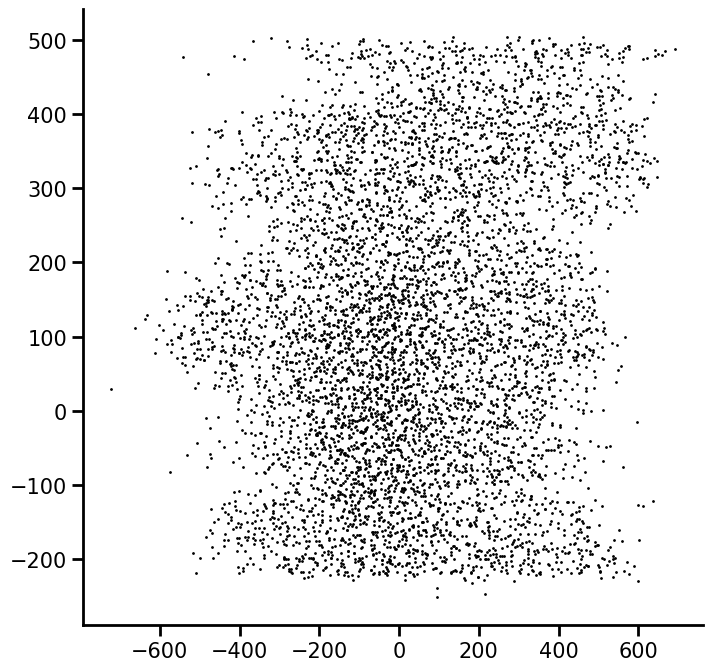

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(sub_cell_df["pt_position_trform_x"] / 1000., sub_cell_df["pt_position_trform_z"] / 1000.,
           c="k", s=1)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Two cells that are far away from each other are probably less likely to connect with each other, right?
Let's calculate the lateral distance between pairs of neurons

In [38]:
def calculate_lateral_distances(cell_df):
    lateral_locations = np.array(cell_df[["pt_position_trform_x", "pt_position_trform_z"]])
    lateral_distances = spatial.distance.cdist(lateral_locations, lateral_locations) / 1000.
    
    id_pairs = list(itertools.product(cell_df["pt_root_id"], cell_df["pt_root_id"]))
    
    lateral_distance_df = pd.DataFrame(id_pairs, columns=['pre_pt_root_id', 'post_pt_root_id'])
    lateral_distance_df['distance'] = lateral_distances.flatten()

    lateral_distance_df = lateral_distance_df[lateral_distance_df['pre_pt_root_id'] != lateral_distance_df['post_pt_root_id']]
    return lateral_distance_df

In [39]:
lateral_distance_df = calculate_lateral_distances(sub_cell_df)

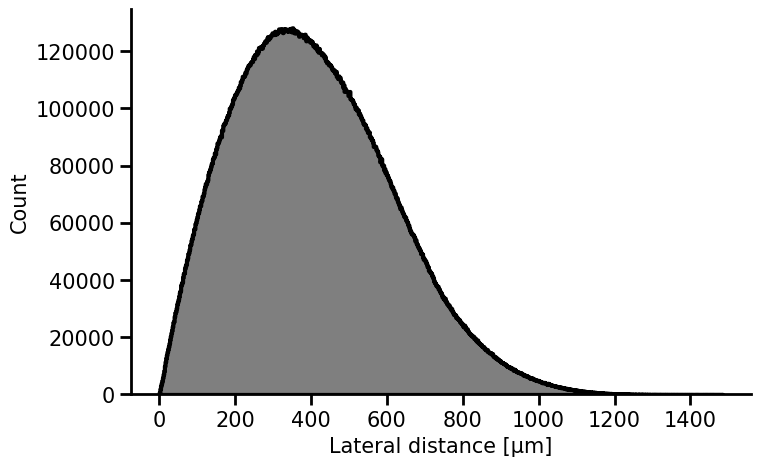

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, x="distance", fill=True, alpha=.5, color="k", lw=3, element="step")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Count", fontsize=15)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The distribution above is specific to our dataset. Let's combine it with the connectivity information to see how far connected neurons are from each other. For that, we combine the IDs we selected from our cell table with the proofreading information.

In [41]:
pre_root_ids = axon_proof_root_ids[np.isin(axon_proof_root_ids, sub_cell_df["pt_root_id"])]
post_root_ids = dendrite_proof_root_ids[np.isin(dendrite_proof_root_ids, sub_cell_df["pt_root_id"])]

analysis_syn_df = filter_synapse_table(syn_df, pre_root_ids, post_root_ids).reset_index(drop=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Some neurons are connected with multiple synapses. Here, we will add them together to a single connection.

</div>

In [42]:
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's combine the connected neurons with the information about the distance between neurons.

In [43]:
conn_df.head(5)

,pre_pt_root_id,post_pt_root_id,size
0,864691132548503618,864691132543938961,2388
1,864691132548503618,864691132569612060,2471
2,864691132548503618,864691132574630714,3758
3,864691132548503618,864691132578853908,4049
4,864691132548503618,864691132579802898,405


In [44]:
lateral_distance_df.head(5)

,pre_pt_root_id,post_pt_root_id,distance
1,864691132654552792,864691132956447079,129.619366
2,864691132654552792,864691132726948075,538.383594
3,864691132654552792,864691132717799744,351.620849
4,864691132654552792,864691132656979312,327.915267
5,864691132654552792,864691132681577381,594.564370


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> Write the merge function to combine the distance and synapse information of the two tables. Note that the connectivity table has far fewer entries from the other. By merging them, we can filter the distance table down to the neuron pairs for which we have a synaptic connection.

</div>

In [45]:
conn_dist_df = pd.merge(conn_df, lateral_distance_df, on=["pre_pt_root_id", "post_pt_root_id"])

In [46]:
conn_dist_df.shape, conn_df.shape, lateral_distance_df.shape

((9579, 4), (9579, 3), (40455960, 3))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's compare the two distribution in plot. We use `stat="probability"` to plot them at the same scale.

</d>

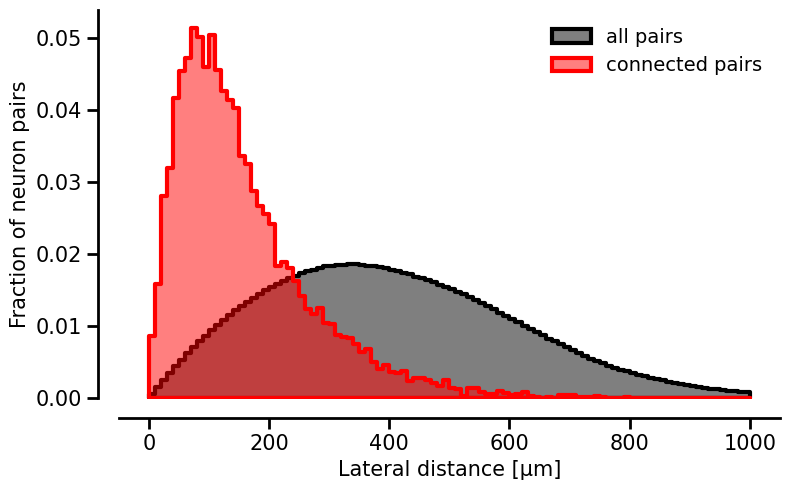

In [61]:
bins = np.linspace(0, 1000, 101)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, x="distance", stat="probability", bins=bins, element="step", label="all pairs", lw=3, fill=True, alpha=.5, color="k")
sns.histplot(conn_dist_df, x="distance", stat="probability", bins=bins, element="step", label="connected pairs", lw=3, fill=True, alpha=.5, color="r")

ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To get some better intution, we will look at some examples of connected neuron pairs across distance:

- 10µm: Neuroglancer link
- 50µm: Neuroglancer link
- 100µm: Neuroglancer link
- 500µm: Neuroglancer link

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Question:</b> Is this a fair comparison? Does our NULL distributionn, the one of all pairs, represent a fair comparison?

</div>

In [62]:
lateral_distance_proofread_df = lateral_distance_df.copy()
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["pre_pt_root_id"], pre_root_ids)]
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["post_pt_root_id"], post_root_ids)]

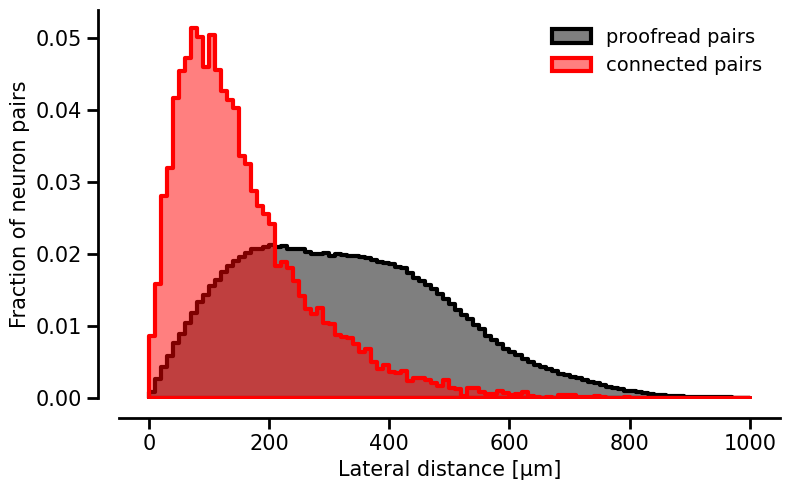

In [63]:
bins = np.linspace(0, 1000, 101)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_proofread_df, x="distance", stat="probability", bins=bins, element="step", label="proofread pairs", lw=3, fill=True, alpha=.5, color="k")
sns.histplot(conn_dist_df, x="distance", stat="probability", bins=bins, element="step", label="connected pairs", lw=3, fill=True, alpha=.5, color="r")

ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)
sns.despine(offset=15, trim=False)
plt.tight_layout()

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Another way to represent the data above is to calculate a "connection probability". That is, how likely is that two neurons are connected given their lateral distance from each other? 

There are different ways to achieve this, here we will calculate the connection probability for every distance bin.

In [64]:
bins = np.linspace(0, 500, 101)
proofread_pair_counts = np.histogram(lateral_distance_proofread_df["distance"], bins)[0]
connected_pair_counts = np.histogram(conn_dist_df["distance"], bins)[0]

connection_probability = connected_pair_counts / proofread_pair_counts

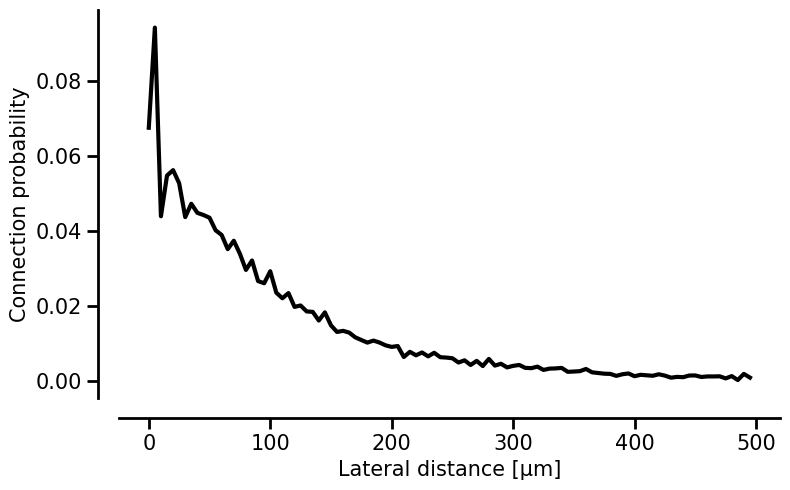

In [65]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x=bins[:-1], y=connection_probability, lw=3, color="k")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

### #2: Reciprocal connections

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### #3: Structure vs function

The V1dd dataset is a structure function dataset. We have functional measurements for many cells in the datasets. These are very rich and can be related to behavioral data. The data is stored in nwb files. Here is an example of the data that is accesible:

In [66]:
# Plot of nwb files

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We precalculated correlations between cells. To be more precise, we calculated the total correlation of the activity traces of neurons imaged during the same section during the same session type.

In [67]:
corr_df = pd.read_feather(f"{data_dir}/cell_cell_correlations_by_stimulus.feather")

In [68]:
corr_df.head(5)

,pre_roi,post_roi,pre_plane,post_plane,column,volume,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous
0,0,1,0,0,1,3,0.109838,0.064885,0.163459,0.147359,0.051569,0.713072,0.034445
1,0,2,0,0,1,3,0.037336,0.018882,0.118983,0.121114,0.043196,-0.016212,-0.012860
2,0,3,0,0,1,3,0.105222,0.040017,0.143078,0.174046,0.001986,0.031184,0.018119
3,0,4,0,0,1,3,0.110601,0.116608,0.144799,0.176239,0.156260,0.016074,0.085105
4,0,5,0,0,1,3,0.026775,0.067496,0.041084,0.131254,0.041494,-0.081003,0.075696


In [69]:
stimulus_conditions = corr_df.columns[6:]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's plot the distribution of a subset of the neuron pairs for the different stimulus conditions

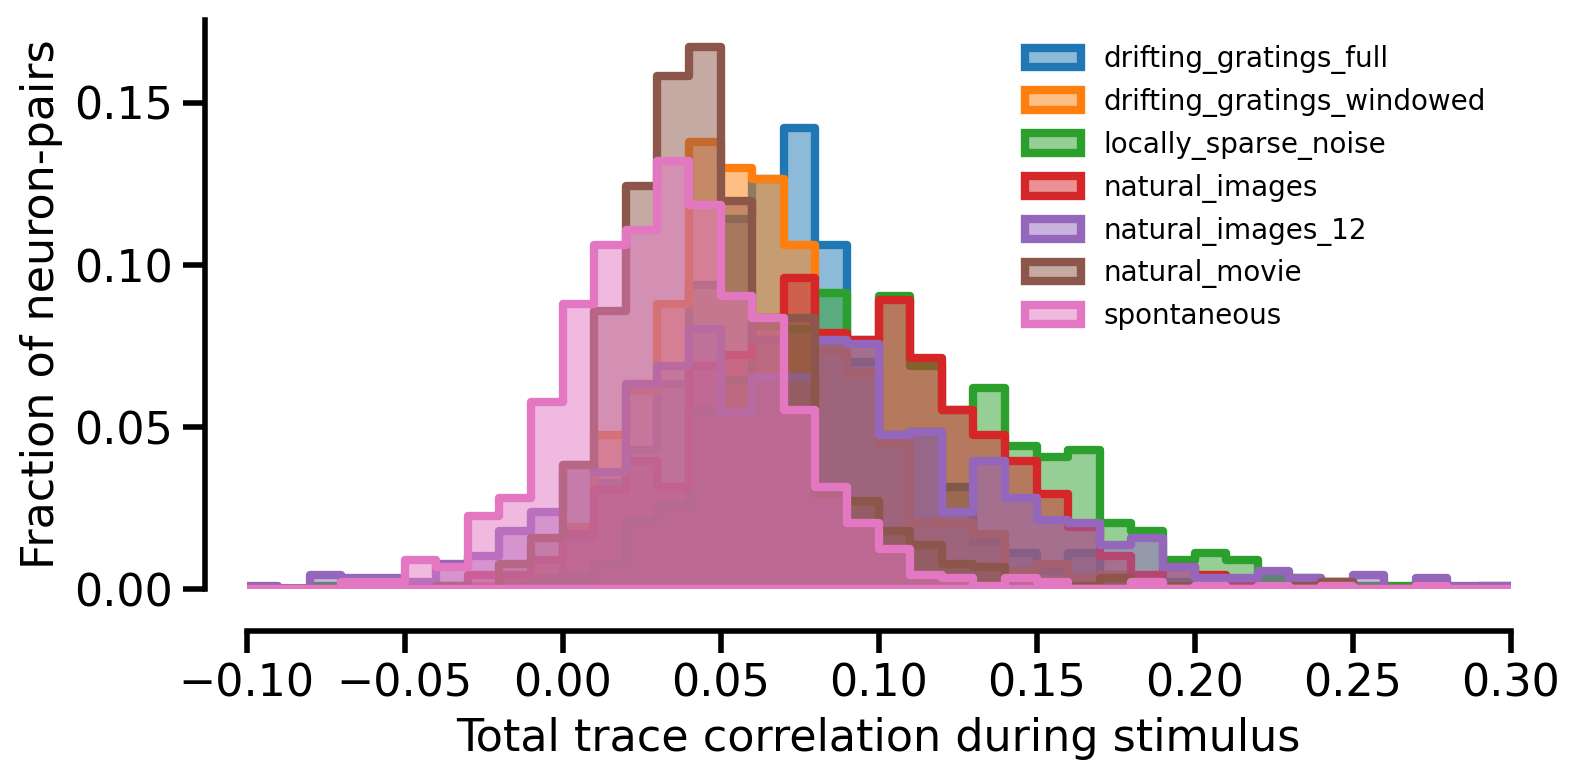

In [70]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

for stim in stimulus_conditions:
    sns.histplot(data=corr_df.iloc[::10000], x=stim, label=stim, bins=np.linspace(-1, 1, 201), 
                 element="step", lw=3, ax=ax, stat="probability", alpha=.5)

ax.legend(frameon=False)
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine
ax.set_xlim(-.1, .3)

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Fraction of neuron-pairs", fontsize=16)
sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

With the activity correlation between neurons in hand, we want to answer one question: Are neurons that are connected with each other more correlated? 

To combine the activity data with the connectivity data, we need to load the coregistration information. The coregistration links ROIs identified in the functional data stack (`[roi, plane, column, volume]`) with a `root_id` in the connectivity tables.

In [71]:
coreg_df = pd.read_feather(f"{data_dir}/coregistration_{mat_version}.feather")

In [72]:
coreg_df.head(5)

,pt_root_id,column,volume,plane,roi
0,864691132999240117,1,3,0,100
1,864691132760377194,1,3,0,60
2,864691132722099342,1,3,5,105
3,864691132669678865,1,3,5,12
4,864691132672748757,1,3,4,232


In [79]:
corr_coreg_df = corr_df.copy()
corr_coreg_df = pd.merge(corr_coreg_df.rename(columns={"pre_roi": "roi", "pre_plane": "plane"}), coreg_df.rename(columns={"pt_root_id": "pre_pt_root_id"}), on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "pre_roi", "plane": "pre_plane"})
corr_coreg_df = pd.merge(corr_coreg_df.rename(columns={"post_roi": "roi", "post_plane": "plane"}), coreg_df.rename(columns={"pt_root_id": "post_pt_root_id"}), on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "post_roi", "plane": "post_plane"})

In [593]:
# snr_df = pd.read_feather(f"{data_dir}/snr_by_cell.feather")
# snr_coreg_df = pd.merge(snr_df, coreg_df, on=["column", "volume", "plane", "roi"])
# corr_coreg_df = pd.merge(corr_coreg_df.rename(columns={"post_roi": "roi", "post_plane": "plane"}), snr_df.rename(columns={"snr": "post_snr"}), on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "post_roi", "plane": "post_plane"})
# corr_coreg_df = pd.merge(corr_coreg_df.rename(columns={"post_roi": "roi", "post_plane": "plane"}), snr_df.rename(columns={"snr": "pre_snr"}), on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "post_roi", "plane": "post_plane"})

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

As before, we will limit this analysis to L3-IT neurons

In [80]:
sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]

In [96]:
# Make this into a get_conn_df function

pre_root_ids = axon_proof_root_ids[np.isin(axon_proof_root_ids, sub_cell_df["pt_root_id"])]
post_root_ids = dendrite_proof_root_ids[np.isin(dendrite_proof_root_ids, sub_cell_df["pt_root_id"])]

analysis_syn_df = filter_synapse_table(syn_df, axon_proof_root_ids, dendrite_proof_root_ids).reset_index(drop=True)
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

In [97]:
corr_coreg_proofread_df = corr_coreg_df.copy()
corr_coreg_proofread_df = corr_coreg_proofread_df[np.isin(corr_coreg_proofread_df["pre_pt_root_id"], pre_root_ids)]
corr_coreg_proofread_df = corr_coreg_proofread_df[np.isin(corr_coreg_proofread_df["post_pt_root_id"], post_root_ids)]

In [98]:
conn_corr_df = pd.merge(conn_df, corr_coreg_proofread_df, on=["pre_pt_root_id", "post_pt_root_id"])

In [99]:
stim = stimulus_conditions[2]
stim

'locally_sparse_noise'

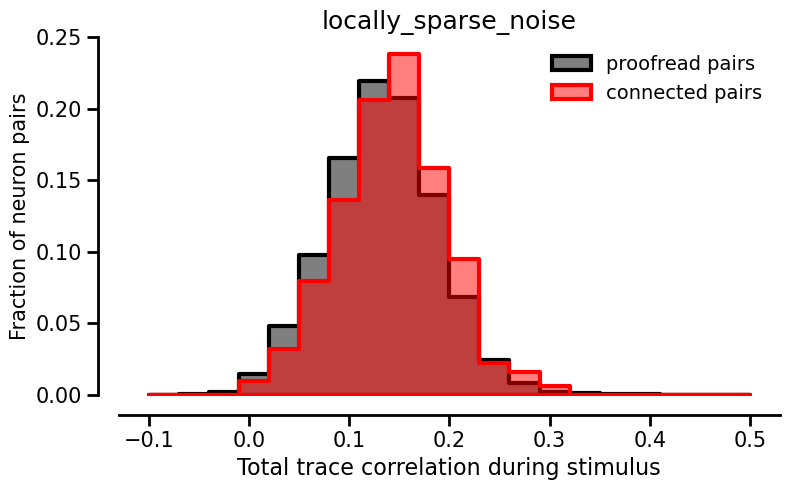

In [105]:
bins=np.linspace(-.1, .5, 21)

fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title(stim, fontsize=18)

sns.histplot(corr_coreg_proofread_df, x=stim, stat="probability", bins=bins, element="step", label="proofread pairs", lw=3, fill=True, alpha=.5, color="k")
sns.histplot(conn_corr_df, x=stim, stat="probability", bins=bins, element="step", label="connected pairs", lw=3, fill=True, alpha=.5, color="r")

ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)
sns.despine(offset=15, trim=False)
plt.tight_layout()

plt.show()

In [106]:
stim = stimulus_conditions[2]

bins = np.percentile(corr_coreg_proofread_df[stim], np.linspace(0, 100, 21))
proofread_pair_counts = np.histogram(corr_coreg_proofread_df[stim], bins)[0]
connected_pair_counts = np.histogram(conn_corr_df[stim], bins)[0]

connection_probability = connected_pair_counts / (proofread_pair_counts + 1e-6)

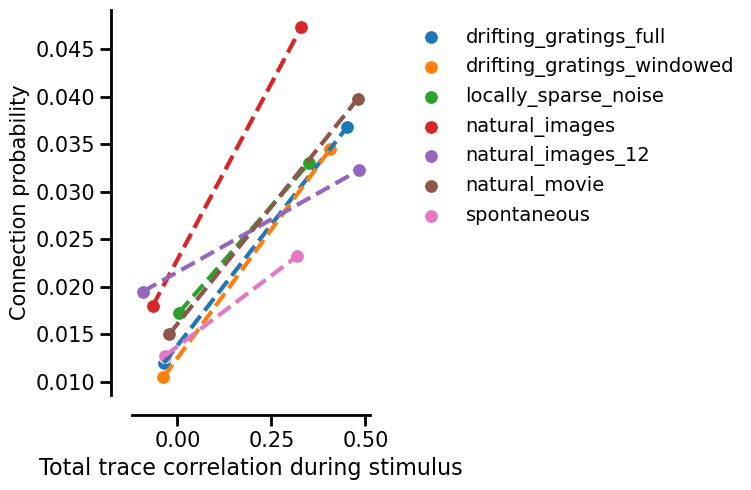

In [128]:
fig, ax = plt.subplots(figsize=(8, 5))

for stim in stimulus_conditions:
    bins = np.linspace(-.1, .3, 6)
    bins = np.percentile(corr_coreg_proofread_df[stim], np.linspace(0, 100, 11))[1:-1]
    bins = np.percentile(corr_coreg_proofread_df[stim], np.linspace(0, 100, 11))[[0, 1, -2, -1]]

    bin_centers = np.convolve(bins, [.5, .5], mode="valid")[[0, -1]]
    proofread_pair_counts = np.histogram(corr_coreg_proofread_df[stim], bins)[0][[0, -1]]
    connected_pair_counts = np.histogram(conn_corr_df[stim], bins)[0][[0, -1]]
    
    connection_probability = connected_pair_counts / (proofread_pair_counts + 1e-6)
    
    sns.lineplot(x=bin_centers, y=connection_probability, lw=3, ls="--", legend=False, ax=ax)
    sns.scatterplot(x=bin_centers, y=connection_probability, label=stim, legend=False, ax=ax, s=100)

ax.legend(frameon=False, fontsize=14)
ax.get_legend().set_bbox_to_anchor([1.1, 1])
ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

## Using null models to investigate underlying principles. Using distance->connectivity as a NULL model

In our structure-function analysis, we used all neuron pairs as comparison basis. This was our NULL model. However, we know that neurons connect to each other based on how close they are to each other. Can this spatial prior explain the modest increase in functional correlation we are observing? 

In [288]:
bins = np.linspace(0, 400, 41)
proofread_pair_counts = np.histogram(lateral_distance_proofread_df["distance"], bins)[0]
connected_pair_counts = np.histogram(conn_dist_df["distance"], bins)[0]

connection_probability = connected_pair_counts / proofread_pair_counts

Let's build a dataframe that contains all our data

In [296]:
full_df = corr_coreg_proofread_df.copy()
full_df = pd.merge(full_df, lateral_distance_proofread_df, on=["pre_pt_root_id", "post_pt_root_id"])
full_df = pd.merge(full_df, conn_df, on=["pre_pt_root_id", "post_pt_root_id"], how="left").fillna(0)
full_df["connected"] = np.array(full_df["size"] > 0)

In [437]:
bins = np.linspace(0, 400, 11)
full_df["distance_bin"] = np.digitize(full_df["distance"], bins)
bin_to_conn_proba = full_df.groupby("distance_bin")["connected"].mean().to_dict()
full_df["conn_proba"] = full_df["distance_bin"].map(bin_to_conn_proba)

In [522]:
stim = stimulus_conditions[3]

In [523]:
connected_mean_corr = full_df[full_df["connected"]][stim].mean()
notconnected_mean_corr = full_df[~full_df["connected"]][stim].mean()

connected_mean_corr, notconnected_mean_corr

(np.float64(0.11141551284555128), np.float64(0.09270566243149558))

In [524]:
full_sampled_df = full_df.copy()

n_connected = np.sum(full_sampled_df["connected"])
sample_probas = np.array(full_sampled_df["conn_proba"])
sample_probas /= np.sum(sample_probas)

sampled_mean_corrs = []
for _ in tqdm.tqdm(range(10_000)):
    sampled_idx = np.random.choice(full_sampled_df.index, p=sample_probas, size=np.sum(full_sampled_df["connected"]))
    full_sampled_df["connected_sampled"] = False
    full_sampled_df.loc[sampled_idx, "connected_sampled"] = True

    sampled_mean_corrs.append(full_sampled_df[full_sampled_df["connected_sampled"]][stim].mean())

100%|█████████████████████████████████████| 10000/10000 [00:03<00:00, 2605.47it/s]


100%|█████████████████████████████████████| 10000/10000 [00:04<00:00, 2471.77it/s]


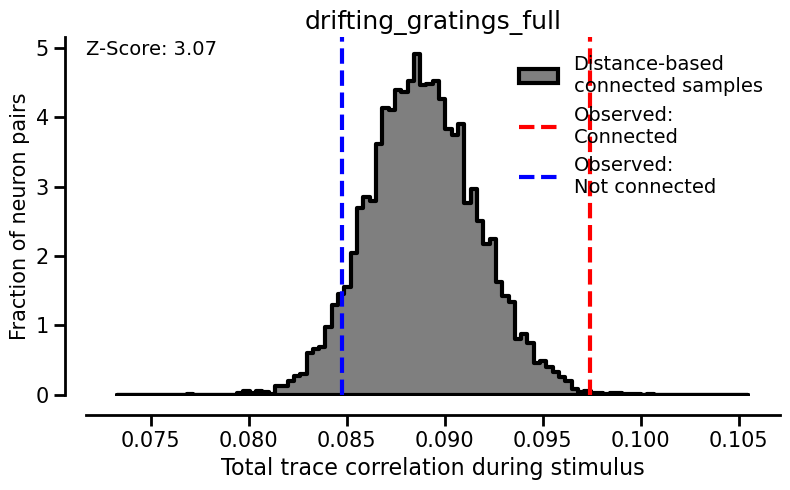

100%|█████████████████████████████████████| 10000/10000 [00:04<00:00, 2440.96it/s]


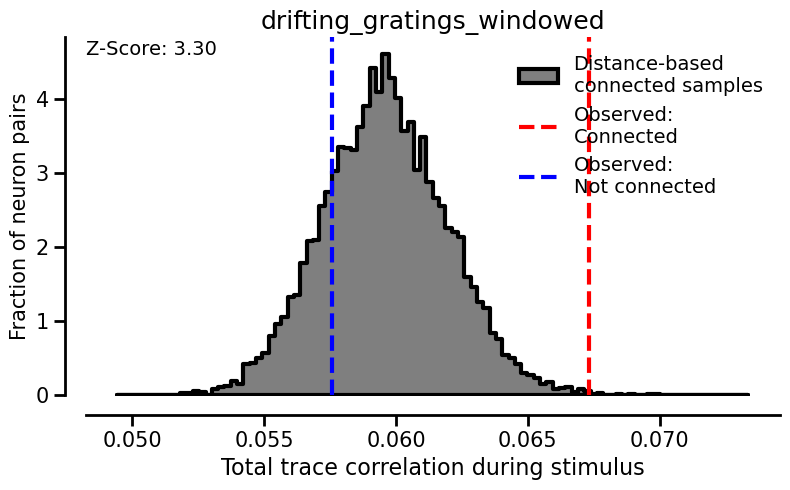

100%|█████████████████████████████████████| 10000/10000 [00:03<00:00, 2626.80it/s]


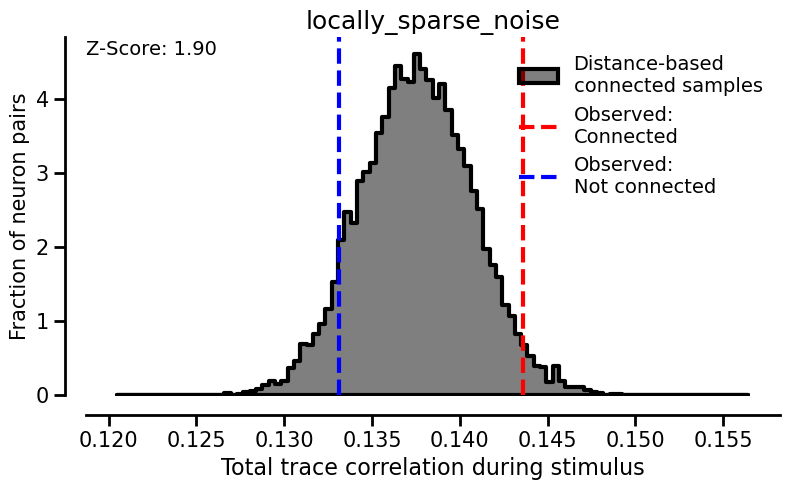

100%|█████████████████████████████████████| 10000/10000 [00:04<00:00, 2462.62it/s]


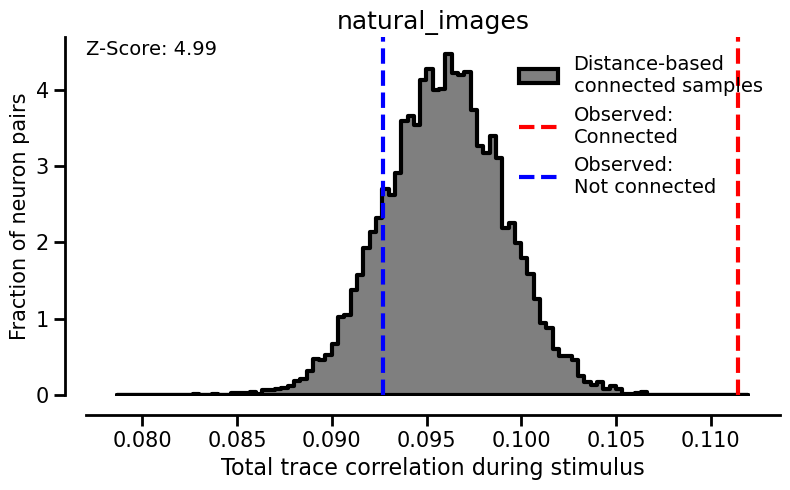

100%|█████████████████████████████████████| 10000/10000 [00:03<00:00, 2626.84it/s]


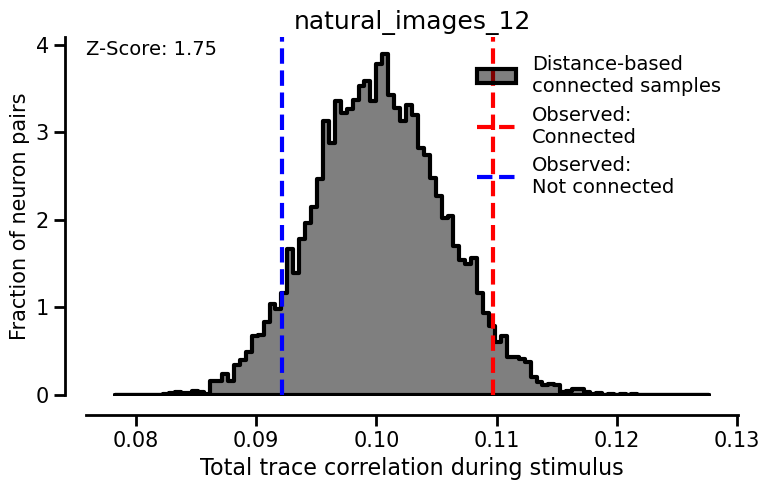

100%|█████████████████████████████████████| 10000/10000 [00:03<00:00, 2635.72it/s]


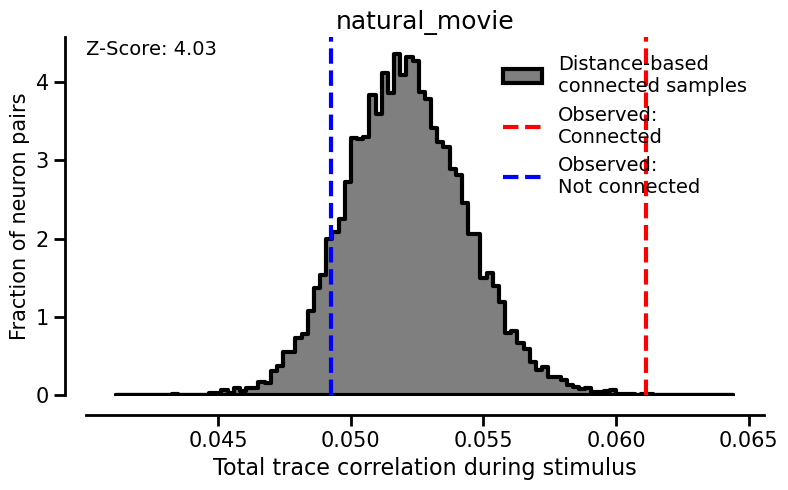

100%|█████████████████████████████████████| 10000/10000 [00:03<00:00, 2657.80it/s]


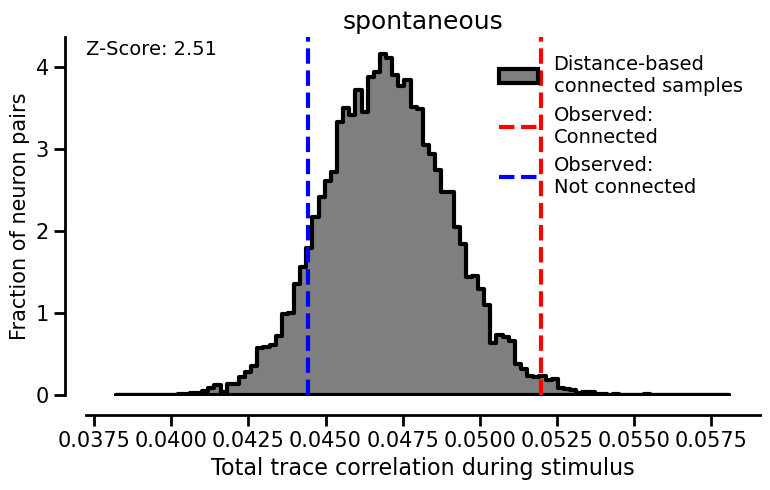

In [536]:
for stim in stimulus_conditions:

    connected_mean_corr = full_df[full_df["connected"]][stim].mean()
    notconnected_mean_corr = full_df[~full_df["connected"]][stim].mean()
    
    connected_mean_corr, notconnected_mean_corr

    full_sampled_df = full_df.copy()
    
    n_connected = np.sum(full_sampled_df["connected"])
    sample_probas = np.array(full_sampled_df["conn_proba"])
    sample_probas /= np.sum(sample_probas)
    
    sampled_mean_corrs = []
    for _ in tqdm.tqdm(range(10_000)):
        sampled_idx = np.random.choice(full_sampled_df.index, p=sample_probas, size=np.sum(full_sampled_df["connected"]))
        full_sampled_df["connected_sampled"] = False
        full_sampled_df.loc[sampled_idx, "connected_sampled"] = True
    
        sampled_mean_corrs.append(full_sampled_df[full_sampled_df["connected_sampled"]][stim].mean())
    
    zscore = (connected_mean_corr - np.mean(sampled_mean_corrs)) / np.std(sampled_mean_corrs)
    
    bins = np.linspace(np.min(sampled_mean_corrs) * .95, np.max(sampled_mean_corrs) * 1.05, 101)
                       
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.set_title(stim, fontsize=18)
    
    sns.histplot(x=sampled_mean_corrs, stat="percent", bins=bins, element="step", label="Distance-based\nconnected samples", 
                 lw=3, fill=True, alpha=.5, color="k")
    
    ax.axvline(x=np.mean(full_df[stim][full_df["connected"]]), color='r', linestyle='--', label='Observed:\nConnected', lw=3)
    ax.axvline(x=np.mean(full_df[stim][~full_df["connected"]]), color='b', linestyle='--', label='Observed:\nNot connected', lw=3)
    
    
    ax.legend(frameon=False, fontsize=14)
    
    ax.text(ax.get_xlim()[0], ax.get_ylim()[1] * .95, f"Z-Score: {zscore:.2f}", fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
    ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels
    
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
    ax.spines['left'].set_linewidth(2)  # Hide the right spine
    
    ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
    ax.set_ylabel("Fraction of neuron pairs", fontsize=15)
    sns.despine(offset=15, trim=False)
    plt.tight_layout()
    
    plt.show()

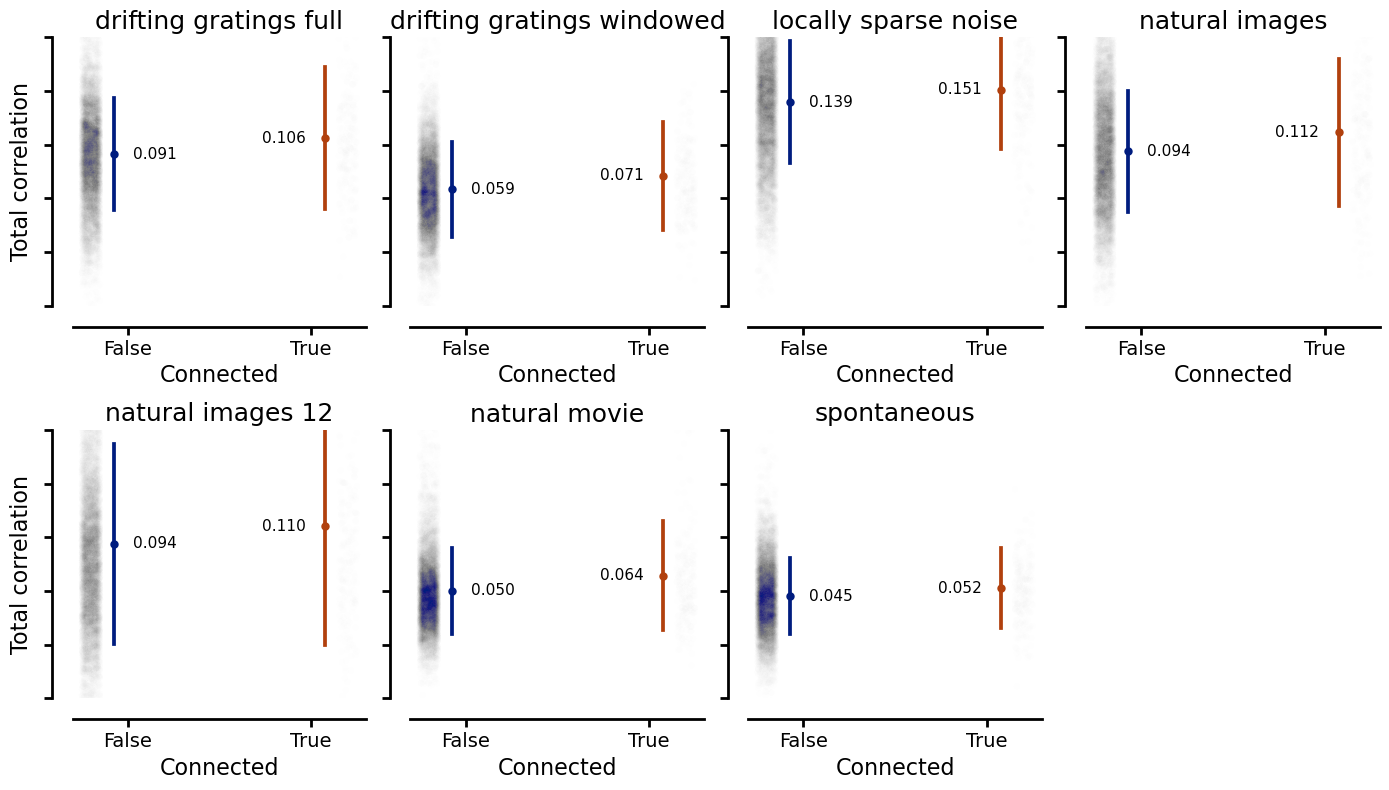

In [212]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8), sharey=True)
axes = axes.flatten()  # flatten to 1D list for easy indexing

for stim, ax in zip(stim_list, axes):
    means = corr_conn_full_df.groupby("connected")[stim].mean()
    ax.set_title(stim.replace("_", " "), fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14, width=2, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=12, width=1, length=4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    sns.stripplot(
        data=corr_conn_full_df, y=stim, x="connected", hue="connected",
        alpha=0.005, palette="dark", dodge=0.15, legend=False, ax=ax
    )

    sns.pointplot(
        data=corr_conn_full_df, x="connected", y=stim, hue="connected",
        dodge=0.15, palette="dark", errorbar="sd",
        markers="o", markersize=4, linestyle="none", ax=ax, legend=False
    )

    # Annotate means at custom x positions
    ax.text(0.15, means.loc[False], f"{means.loc[False]:.3f}", ha="center", va="center", fontsize=11, color="black")
    ax.text(0.85, means.loc[True], f"{means.loc[True]:.3f}", ha="center", va="center", fontsize=11, color="black")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["False", "True"], fontsize=14)

    if ax is axes[0] or ax is axes[4]:  # left-most in each row
        ax.set_ylabel("Total correlation", fontsize=16)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    ax.set_xlabel("Connected", fontsize=16)
    ax.set_ylim(-.05, .2)
    ax.set_xlim(-0.3, 1.3)

# Hide any unused subplot (e.g., the 8th panel)
if len(stim_list) < len(axes):
    for ax in axes[len(stim_list):]:
        ax.axis('off')

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()
